# Learning Platform

This is the pilot of analysis. Must gather some questions. Theme maybe?

```Learn from Student City```

Steps:

1. Summarize the data
2. Districts Groups
3. Platform Essentials


In [1]:
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gc

import sys
sys.path.append('../src/')
import common

In [2]:
BASE_PATH = '../data/'
PATH_DATA = BASE_PATH+'engagement_data/'

### Content 

* [Summarize The Data](#first-bullet)
* [Student City](#second-bullet)
* [Essentials](#third-bullet)

Notes :
A student from a household with an income at or below 130 percent of the poverty income threshold is eligible for free lunch. A student from a household with an income between 130 percent and up to 185 percent of the poverty threshold is eligible for reduced price lunch. [source](https://nces.ed.gov/blogs/nces/post/free-or-reduced-price-lunch-a-proxy-for-poverty#:~:text=A%20student%20from%20a%20household,eligible%20for%20reduced%20price%20lunch.)

## Summarize The Data <a class="anchor" id="first-bullet"></a>

In [3]:
# df_eng = pd.DataFrame()
# for f in [i for i in os.listdir(PATH_DATA) if '.csv' in i]:
#     df_temp = pd.read_csv(PATH_DATA+f)
#     df_temp['district_id'] = f[:-4]
#     df_eng = df_eng.append(df_temp)
    
# df_eng = df_eng.reset_index()
# del df_eng['index']
# df_eng.to_csv(BASE_PATH+'eng_merge.csv',index = False)

df_eng = pd.read_csv(BASE_PATH+'eng_merge.csv')
df_distr = pd.read_csv(BASE_PATH+'districts_info.csv')
df_product = pd.read_csv(BASE_PATH+'products_info.csv')

In [4]:
## Functions

def matrix_normalize(d0, axis = 1):
    if axis:
        d1 = ((d0.transpose()/d0.sum(axis = 1)).transpose())
    else:
        d1 = (d0/d0.sum())
    return d1

# def matrix_viz():

In [5]:
df_eng.shape

(22324190, 5)

In [6]:
df_eng.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,93690.0,0.00,NaN,1000
1,2020-01-01,17941.0,0.03,0.90,1000
2,2020-01-01,65358.0,0.03,1.20,1000
3,2020-01-01,98265.0,0.57,37.79,1000
4,2020-01-01,59257.0,0.00,NaN,1000


In [7]:
df_distr.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_product.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


### Districts, Products and Engagements

seperate summary of each table.

In [9]:
df_distr.isnull().sum()

district_id                   0
state                        57
locale                       57
pct_black/hispanic           57
pct_free/reduced             85
county_connections_ratio     71
pp_total_raw                115
dtype: int64

In [10]:
df_product.isnull().sum()

LP ID                          0
URL                            0
Product Name                   0
Provider/Company Name          1
Sector(s)                     20
Primary Essential Function    20
dtype: int64

In [11]:
df_eng.isnull().sum()

time                      0
lp_id                   541
pct_access            13447
engagement_index    5378409
district_id               0
dtype: int64

In [12]:
df_eng[df_eng['engagement_index'].isnull()].pct_access.unique()

array([ 0., nan])

In [13]:
# df_eng[df_eng['pct_access'].isnull()].engagement_index.unique()
df_eng[df_eng['pct_access']==0].engagement_index.quantile(0.95)  ## --> pct == 0 probably too small

0.94

In [14]:
## Preparation
df_eng['time'] = pd.to_datetime(df_eng['time'])
df_eng['day'] = df_eng['time'].dt.strftime('%Y-%m-%d')
df_eng['weeks'] = df_eng['time'].dt.strftime('%W')
df_eng['weekday'] = df_eng['time'].dt.strftime('%w')
df_eng['is_weekend'] = df_eng['weekday'].isin(['0','6'])

df_distr['locale'] = df_distr['locale'].fillna('unknown')
df_eng['lp_id'] = df_eng['lp_id'].fillna(-1)

df_eng['lp_id'] = df_eng['lp_id'].astype(int).astype(str)
df_product['LP ID'] = df_product['LP ID'].astype(int).astype(str)
df_product['Primary Essential Function'] = df_product[
                'Primary Essential Function'].fillna('Unknown-Unknown')

df_product['product_functions'] = df_product['Primary Essential Function'].apply(
    lambda x : x.split('-')[0].strip())

df_product['product_essential'] = df_product['Primary Essential Function'].apply(
    lambda x : x.split('-')[1].strip())

df_product['product_essential'] = df_product['product_essential'].replace(
            {'Sites, Resources & References':
                         'Sites, Resources & Reference'})

#### Districts

In [15]:
len(df_eng.district_id.unique()) ## --> 233 district

233

In [16]:
df_distr.shape

(233, 7)

In [17]:
df_distr.groupby('locale')['district_id'].size().sort_values(ascending=False)

locale
Suburb     104
unknown     57
Rural       33
City        29
Town        10
Name: district_id, dtype: int64

In [18]:
df_distr.groupby('county_connections_ratio').size() ## not really informatif

county_connections_ratio
[0.18, 1[    161
[1, 2[         1
dtype: int64

In [19]:
df_distr.groupby('pct_black/hispanic').size()

pct_black/hispanic
[0, 0.2[      116
[0.2, 0.4[     24
[0.4, 0.6[     17
[0.6, 0.8[     11
[0.8, 1[        8
dtype: int64

In [20]:
df_distr.groupby('pct_free/reduced').size()

pct_free/reduced
[0, 0.2[      46
[0.2, 0.4[    48
[0.4, 0.6[    37
[0.6, 0.8[    13
[0.8, 1[       4
dtype: int64

In [21]:
df_distr.groupby('pp_total_raw').size()

pp_total_raw
[10000, 12000[    17
[12000, 14000[    15
[14000, 16000[    15
[16000, 18000[    13
[18000, 20000[     8
[20000, 22000[     2
[22000, 24000[     2
[32000, 34000[     1
[4000, 6000[       2
[6000, 8000[      13
[8000, 10000[     30
dtype: int64

In [22]:
fr_hb_matrix = df_distr.groupby(['pct_black/hispanic',
            'pct_free/reduced']).size().unstack().fillna(0)

In [23]:
plt.figure(figsize = (15,8))
sns.set(font_scale=1.15)
sns.heatmap(matrix_normalize(fr_hb_matrix)
                ,annot= True, fmt = '.2%', linewidths=0.5
                ,vmax = 0.48)

<AxesSubplot:xlabel='pct_free/reduced', ylabel='pct_black/hispanic'>

In [24]:
## F test to see the correlation

In [25]:
df_distr['state'].value_counts()[:15]

Connecticut             30
Utah                    29
Massachusetts           21
Illinois                18
California              12
Ohio                    11
New York                 8
Indiana                  7
Missouri                 6
Washington               6
North Carolina           4
Virginia                 4
Wisconsin                3
District Of Columbia     3
Tennessee                2
Name: state, dtype: int64

#### Products

In [26]:
len(df_eng.lp_id.unique()) ## --> 8647 products

8647

In [27]:
df_product.shape ## but we only have 372 data products details (top 372)

(372, 8)

In [28]:
len(set(df_eng.lp_id.unique()) - set(df_product['LP ID']))

8278

In [29]:
df_eng['has_lp_details'] = df_eng.lp_id.isin(df_product['LP ID']).astype(int)
df_eng2 = df_eng[df_eng.has_lp_details == 0]

In [30]:
df_eng2.shape[0]/df_eng.shape[0]

0.4762816926392402

In [31]:
df_product['Sector(s)'].value_counts()

PreK-12                          170
PreK-12; Higher Ed; Corporate    115
PreK-12; Higher Ed                65
Higher Ed; Corporate               1
Corporate                          1
Name: Sector(s), dtype: int64

In [32]:
df_product['product_functions'].value_counts()

LC           272
CM            34
SDO           30
Unknown       20
LC/CM/SDO     16
Name: product_functions, dtype: int64

In [33]:
df_product['product_essential'].value_counts() ## --> one essential must have one function

Sites, Resources & Reference                              101
Digital Learning Platforms                                 74
Content Creation & Curation                                36
Study Tools                                                35
Classroom Engagement & Instruction                         20
Unknown                                                    20
Courseware & Textbooks                                     18
Other                                                      18
Data, Analytics & Reporting                                11
Teacher Resources                                           7
Virtual Classroom                                           7
Online Course Providers & Technical Skills Development      5
Learning Management Systems (LMS)                           5
School Management Software                                  4
Human Resources                                             4
Career Planning & Job Search                                3
Large   

In [34]:
df_product['Provider/Company Name'].value_counts()[:15]

Google LLC                                                 30
Houghton Mifflin Harcourt                                   6
Microsoft                                                   6
IXL Learning                                                4
Learning A-Z                                                4
McGraw-Hill PreK-12                                         3
Adobe Inc.                                                  3
Curriculum Associates                                       3
Savvas Learning Company | Formerly Pearson K12 Learning     3
 Autodesk, Inc                                              3
The College Board                                           3
PBS                                                         3
ExploreLearning, LLC                                        3
Scholastic Inc                                              3
ClassDojo, Inc.                                             2
Name: Provider/Company Name, dtype: int64

In [35]:
del df_eng2

In [36]:
# funtion_essential_matrix = df_product.groupby(['product_essential',
#             'product_functions']).size().unstack().fillna(0)

# plt.figure(figsize = (15,8))
# sns.set(font_scale=1.15)
# sns.heatmap(matrix_normalize(funtion_essential_matrix)
#                 ,annot= True, fmt = '.2%', linewidths=0.5
#                 ,vmax = 0.48)

In [37]:
gc.collect()

176

#### Engagements

In [38]:
df_eng.time.min(), df_eng.time.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [39]:
## Daily Pct Access regardless areas or product (Not Null)

## Most of time (more than 98%) less than 5% have at least one page load.
## But there is one day on particular areas (and source) have 100% access.

df_eng[df_eng['pct_access']>=0]['pct_access'].describe()

count    2.231074e+07
mean     5.042399e-01
std      3.180568e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e-02
75%      9.000000e-02
max      1.000000e+02
Name: pct_access, dtype: float64

In [40]:
df_eng['pct_access'].quantile(0.98)

4.85

In [41]:
sns.displot(df_eng[(df_eng['pct_access']>=0) & (df_eng['pct_access']<5)]['pct_access'], bins = 40)

In [42]:
# len((df_eng[(df_eng['pct_access']>0) & (df_eng['pct_access']<3)]))/len(df_eng[(df_eng['pct_access']>0)])

In [43]:
df_eng_less5 = df_eng[(df_eng['pct_access']>=0) & (df_eng['pct_access']<5)]

In [44]:
len(df_eng_less5)/len(df_eng)

0.9798725508069945

In [45]:
len(df_eng_less5[df_eng_less5.engagement_index.isnull()])/len(df_eng_less5)

0.24525696414710932

In [46]:
df_eng_less5 = df_eng[(df_eng['pct_access']>=0) & (df_eng['pct_access']<5) & (df_eng['engagement_index']>=0)]
len(df_eng_less5)/len(df_eng)

0.739551983744987

In [47]:
## Daily engagement_index regardless areas or product (Not Zero pct_access)

## Most of time, the engagement index less than 450

df_eng_less5['engagement_index'].describe()

count    1.650990e+07
mean     3.513448e+01
std      1.751640e+02
min      1.000000e-02
25%      3.500000e-01
50%      1.770000e+00
75%      1.137000e+01
max      4.893140e+04
Name: engagement_index, dtype: float64

In [48]:
df_eng_less5['engagement_index'].quantile(0.98),df_eng['engagement_index'].quantile(0.98)

(365.89, 1154.33)

In [49]:
sns.histplot(df_eng_less5[(df_eng_less5['engagement_index']<250)]['engagement_index'], bins = 40)

<AxesSubplot:xlabel='pct_access', ylabel='Count'>

In [50]:
day_size = df_eng.groupby('day').size()
day_unique_product = df_eng.groupby('day')['lp_id'].apply(pd.Series.nunique)
day_unique_areas = df_eng.groupby('day')['district_id'].apply(pd.Series.nunique)
day_mean_eng_less5 = df_eng_less5.groupby('day')['engagement_index'].mean()

In [51]:
del df_eng_less5

In [52]:
gc.collect()

112

In [53]:
day_size.plot(figsize = (15,8))

<AxesSubplot:xlabel='day', ylabel='Count'>

In [54]:
day_size['2020-05-01':'2020-05-15'].plot(figsize = (15,8))

<AxesSubplot:xlabel='day', ylabel='Count'>

In [55]:
day_unique_product.plot(figsize = (15,8))

<AxesSubplot:xlabel='day', ylabel='Count'>

In [56]:
day_unique_areas.plot(figsize = (15,8))

<AxesSubplot:xlabel='day', ylabel='Count'>

In [57]:
day_mean_eng_less5.plot(figsize = (15,8))

<AxesSubplot:xlabel='day', ylabel='Count'>

## E-Student Type <a class="anchor" id="second-bullet"></a>

In [58]:
df_eng.sample(5)

,time,lp_id,pct_access,engagement_index,district_id,day,weeks,weekday,is_weekend,has_lp_details
21290319,2020-09-18,81544,0.01,0.52,9537,2020-09-18,37,5,False,0
6623103,2020-04-27,20050,0.07,10.68,3266,2020-04-27,17,1,False,0
9517006,2020-03-20,29158,0.20,4.93,4314,2020-03-20,11,5,False,1
13427338,2020-12-23,11237,0.02,5.66,6049,2020-12-23,51,3,False,1
21985605,2020-10-08,37296,0.00,0.05,9812,2020-10-08,40,4,False,0


In [59]:
df_eng_on = df_eng[df_eng.engagement_index > 0] 

In [60]:
df_district_summary1 = df_eng_on.groupby('district_id').agg({'day':pd.Series.nunique, 'lp_id': pd.Series.nunique, 
                                                   'engagement_index':np.mean})

In [61]:
df_district_summary1.head()

,day,lp_id,engagement_index
district_id,,,
1000,366,2303,192.102937
1039,366,1363,226.013791
1044,366,5143,88.548682
1052,366,2132,314.999440
1131,347,988,113.538369


In [62]:
len(df_district_summary1)

233

In [63]:
sns.scatterplot(data = df_district_summary1, x = 'lp_id', y = 'engagement_index', hue = 'day')

<AxesSubplot:xlabel='day', ylabel='Count'>

In [64]:
## Capping the engagement index
df_district_summary1.describe()

,day,lp_id,engagement_index
count,233.000000,233.000000,233.000000
mean,331.283262,2337.553648,238.959029
std,79.183803,1141.070304,190.676872
min,13.000000,245.000000,19.488887
25%,350.000000,1483.000000,113.174975
50%,366.000000,2205.000000,182.057322
75%,366.000000,3009.000000,312.204788
max,366.000000,5395.000000,1311.816298


### Areas Clustering

In [65]:
df_district_summary1.engagement_index.quantile(0.95), df_district_summary1.lp_id.quantile(0.95)

(573.4923646943928, 4524.4)

In [66]:
df_district_summary1['engagement_index'] = np.where(df_district_summary1.engagement_index>600, 
                                        600, df_district_summary1.engagement_index)

df_district_summary1['lp_id'] = np.where(df_district_summary1.lp_id>4500, 
                                        4500, df_district_summary1.lp_id)

In [67]:
# ## KMeans
# ss_trf = StandardScaler()
# XX = df_district_summary1.values
# XX_s = ss_trf.fit_transform(XX)

# df_sil_score = pd.DataFrame()
# for j in range(10):
#     k_list = []
#     ss_list = []
#     for kk in [i+2 for i in range(10)]:
# #         k_clus_temp = KMeans(n_clusters = kk)
# #         k_clus_temp.fit(XX_s)
# #         clusters_temp = k_clus_temp.labels_
        
        
#         kclus_temp = SpectralClustering(n_clusters = kk, gamma = 0.8, n_init=25)
#         clustering_fit = kclus_temp.fit(XX_s)
#         clusters_temp = clustering_fit.labels_
        
#         k_list.append(kk)
#         ss_list.append(silhouette_score(XX_s,clusters_temp))
        
#         df_temp = pd.DataFrame({'k_list' : k_list, 'sil_score': ss_list})
#         df_sil_score = df_sil_score.append(df_temp)

# df_sil_score = df_sil_score.reset_index(drop = True)
# sns.boxplot(data = df_sil_score, x = 'k_list', y = 'sil_score')
# plt.vlines(x = 1, ymax=0.58, ymin = 0.32, colors='r')

In [68]:
# ss_trf = StandardScaler()
# XX = df_district_summary1.values
# XX_s = ss_trf.fit_transform(XX)

# df_sil_score = pd.DataFrame()
# for j in range(30):
#     g_list = [0.1,0.6,0.8,1.6,3.2]
#     n_list = [10,15,25,35,50]
    
#     res_sil = []
#     for gg in g_list:
#         for nit in n_list:
#             kclus_temp = SpectralClustering(n_clusters = 3, gamma = gg, n_init=nit
#                                                 , degree=3, n_jobs=3)
#             clustering_fit = kclus_temp.fit(XX_s)
#             clusters_temp = clustering_fit.labels_
#             sil_score = silhouette_score(XX_s,clusters_temp)
            
#             res_sil.append([gg,nit,sil_score])

# df_sil_score2 = pd.DataFrame(res_sil, columns = ['gamma','init','sil_score'])

# hmat = df_sil_score2.groupby(['gamma','init']).mean().unstack()

# plt.figure(figsize = (15,8))
# sns.set(font_scale=1.15)
# sns.heatmap(hmat
#                 ,annot= True, fmt = '.2%', linewidths=0.5
#                 ,vmax = 0.57, vmin = 0.54)

In [69]:
ss_trf = StandardScaler()
XX = df_district_summary1.values
XX_s = ss_trf.fit_transform(XX)

k_clus = KMeans(n_clusters = 3, random_state=100)
k_clus.fit(XX_s)
df_district_summary1['cls'] = k_clus.labels_

### Clusters Description

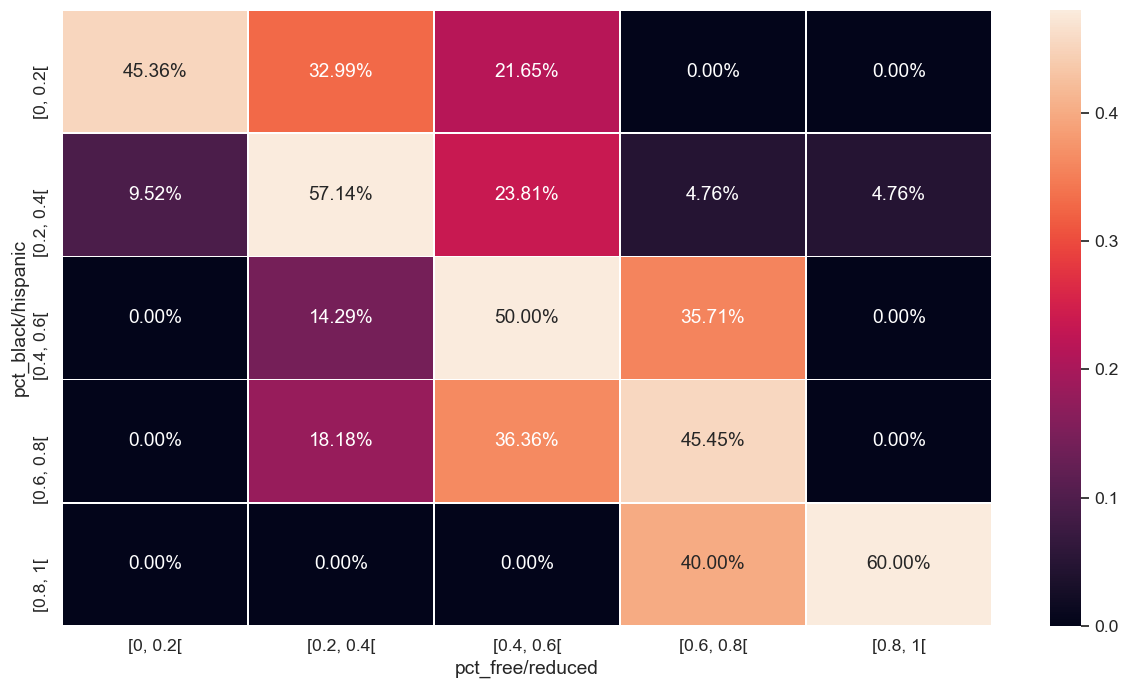

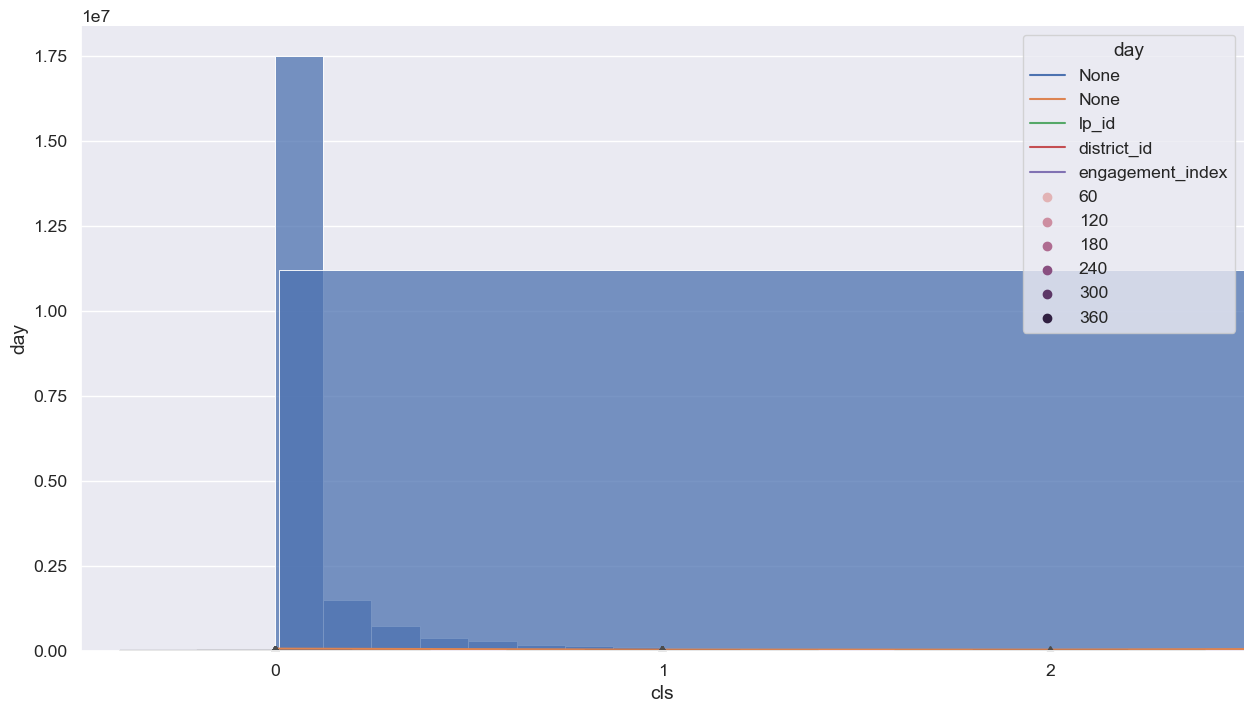

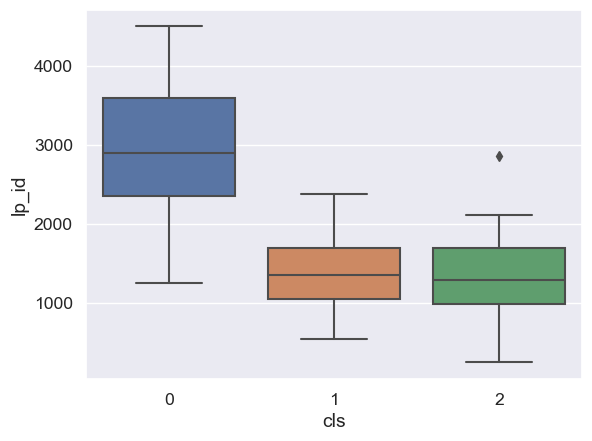

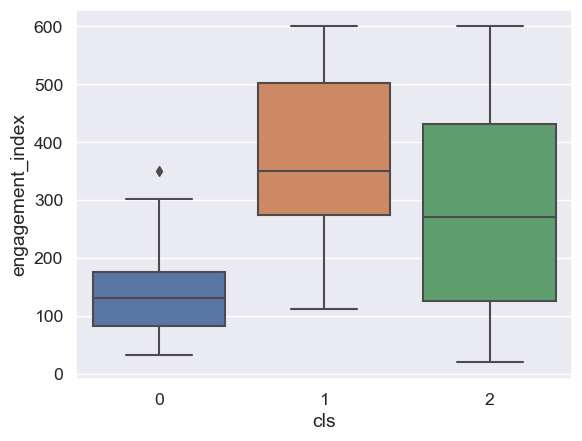

In [70]:
for c in ['day', 'lp_id', 'engagement_index']:
#     sorted_id = df_district_summary1.groupby('cls')[c].quantile(0.5).sort_values().index
    sorted_id = None
    sns.boxplot(data = df_district_summary1, x = 'cls', y = c, order=sorted_id)
    plt.show()

In [71]:
df_district_summary1.groupby('cls').size()

cls
0    134
1     76
2     23
dtype: int64

In [72]:
df_district_summary1.head()

,day,lp_id,engagement_index,cls
district_id,,,,
1000,366,2303,192.102937,0
1039,366,1363,226.013791,1
1044,366,4500,88.548682,0
1052,366,2132,314.999440,1
1131,347,988,113.538369,1


it seems, if areas is high product then it has low engagement. (so? any insight?)

There are 3 clusters :
* 0 --> high active day, high product (the Explorer)
* 1 --> high active day, low product (the Loyal)
* 2 --> low active day, low engagement (the Rookie)

In [73]:
df_district_summary2 = df_district_summary1.reset_index()

In [74]:
df_distr

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,unknown,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,unknown,NaN,NaN,NaN,NaN
4,2238,NaN,unknown,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
228,9515,New York,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[18000, 20000["
229,8103,Tennessee,Rural,"[0.2, 0.4[",NaN,"[0.18, 1[","[8000, 10000["
230,4929,Virginia,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[12000, 14000["
231,7975,California,City,"[0.6, 0.8[","[0.6, 0.8[","[0.18, 1[",NaN


In [75]:
def cluster_desc(col_check):
    hb_cls_mat = df_distr_cls.groupby([col_check,
                            'cls']).size().unstack().fillna(0)
    hb_cls_mat = matrix_normalize(hb_cls_mat, axis = 1).stack().reset_index()
    
    hb_cls_mat = hb_cls_mat.rename(columns = {0 : 'percent_size'})

    sns.barplot(data = hb_cls_mat ,x = col_check, y = 'percent_size', hue = 'cls')

the more pct free, the more probable to be cluster 0.

the more pct free, the least probable to be cluster 1.

In [76]:
df_distr_cls = pd.merge(df_distr, df_district_summary2[['district_id','cls']],
         on = ['district_id'], how = 'left')

In [77]:
cluster_desc('pct_free/reduced')

In [78]:
cluster_desc('locale')

In [79]:
df_distr_cls.groupby(['state','cls']).size().unstack().fillna(0)

cls,0,1,2
state,,,
Arizona,0.0,1.0,0.0
California,9.0,2.0,1.0
Connecticut,14.0,15.0,1.0
District Of Columbia,2.0,0.0,1.0
Florida,1.0,0.0,0.0
Illinois,13.0,3.0,2.0
Indiana,4.0,3.0,0.0
Massachusetts,10.0,11.0,0.0
Michigan,2.0,0.0,0.0


In [80]:
del df_eng_on

In [81]:
gc.collect()

8072

## Platform Essentials <a class="anchor" id="third-bullet"></a>

In [82]:
df_time_only = df_eng[['day','weekday','is_weekend','weeks']].drop_duplicates().reset_index(drop=True)
df_time_only['rr'] = 1

df_district_only = df_eng[['district_id']].drop_duplicates().reset_index(drop=True)
df_district_only['rr'] = 1

df_base_district_time = pd.merge(df_time_only, df_district_only, on = 'rr').reset_index(drop=True)

In [83]:
def q50(x):
    return x.quantile(0.5)

In [166]:
def week_snapshot(wn, df_eng = df_eng, engagement = True, raw_base = False):
    title_f = 'snapshot learn platform week : '+wn
    df_week_temp = df_eng[df_eng.weeks == wn][['day','district_id',
                                            'lp_id','pct_access','engagement_index']]
    df_base_temp = df_base_district_time[df_base_district_time.weeks == wn]
    df_base_eng_temp = pd.merge(df_base_temp, df_week_temp, 
                     on = ['day','district_id'], 
                     how = 'left'
                    )

    df_base_eng_temp = pd.merge(df_base_eng_temp, df_distr_cls[['district_id','cls']], 
                     on = ['district_id'], 
                     how = 'left'
                    )

    df_base_eng_temp['engagement_index2'] = np.where(df_base_eng_temp['engagement_index'] == 0, 1, 
                                                     df_base_eng_temp['engagement_index'].fillna(0)*1000)/100
    df_base_eng_temp['active_day'] =  np.where(df_base_eng_temp['engagement_index2'] != 0,df_base_eng_temp['day'],np.NaN)
    
    df_base_eng_temp = pd.merge(df_base_eng_temp, df_product, 
                     left_on = ['lp_id'], 
                     right_on = ['LP ID'],
                     how = 'left'
                    )
    
    if engagement:
        df_g1 = df_base_eng_temp.groupby(['cls','product_essential']).agg({'engagement_index2':q50}).reset_index()
    else:
        df_g0 = df_base_eng_temp.groupby(['district_id','cls','product_essential']).agg({'LP ID':pd.Series.nunique}).reset_index()
        df_g1 = df_g0.groupby(['cls','product_essential']).agg({'LP ID':q50}).reset_index()

    df_g1['week'] = wn
    if raw_base:
        return df_base_eng_temp
    else:
        return df_g1

In [167]:
df_weekly = pd.DataFrame()
wn_list = ['{:0>2}'.format(i+1) for i in range(45)]
for wn in wn_list:
    df_bb = week_snapshot(wn, engagement=False)
    df_weekly = df_weekly.append(df_bb)
df_weekly = df_weekly.reset_index(drop = True)

In [184]:
## Get top essential
df_lp_p50 = df_weekly.groupby(['product_essential','cls'])['LP ID'].apply(q50).reset_index()
df_lp_p50['RN'] = df_lp_p50.groupby(['cls'])['LP ID'].rank(method='dense', ascending=False).astype(int)
essential_top3 = df_lp_p50[df_lp_p50['RN'] <= 3].product_essential.unique().tolist()
df_weekly_top3 = df_weekly[df_weekly.product_essential.isin(essential_top3)]
len(essential_top3)

6

C:\Users\amoza\anaconda3\envs\droid1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


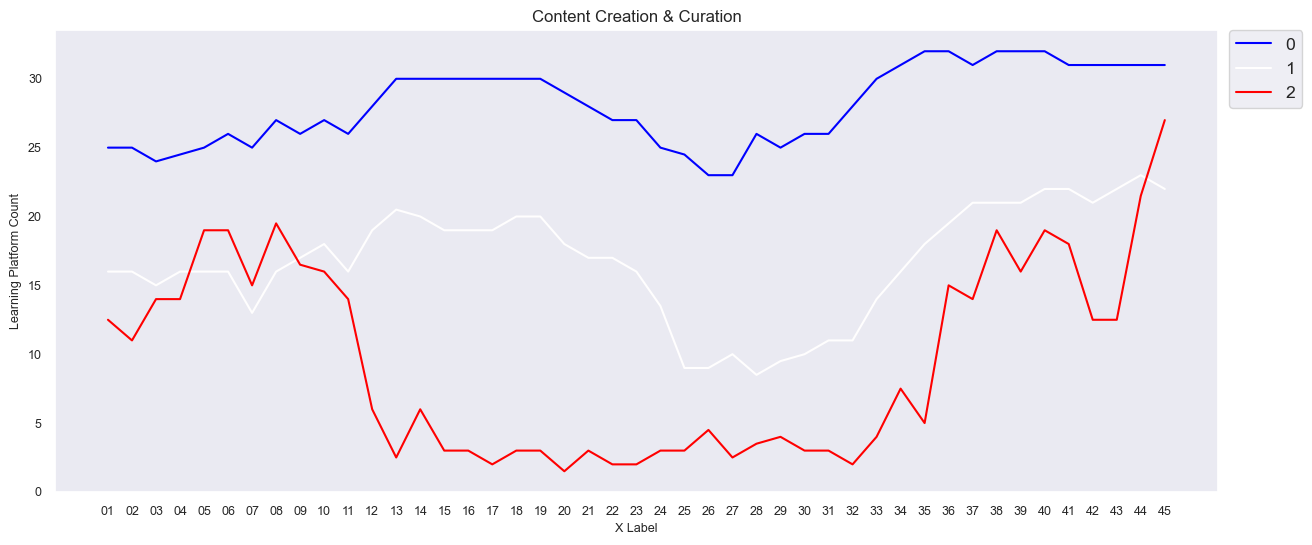

In [185]:
ess = essential_top3[0]
dtemp = df_weekly_top3[df_weekly_top5.product_essential == ess]
# sns.set_style("dark")
plt.figure(figsize=(15,6))
b =sns.lineplot(data = dtemp, x = 'week', y = 'LP ID', hue = 'cls', palette='bwr')
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
b.axes.set_title(ess,fontsize=12)
b.set_xlabel("X Label",fontsize=9)
b.set_ylabel("Learning Platform Count",fontsize=9)
b.tick_params(labelsize=9)
plt.show()

### 

In [188]:
df_lp_p50[df_lp_p50['RN'] <= 3].sort_values(['cls','RN'])

,product_essential,cls,LP ID,RN
42,"Sites, Resources & Reference",0,81.0,1
18,Digital Learning Platforms,0,53.0,2
9,Content Creation & Curation,0,28.0,3
45,Study Tools,0,28.0,3
43,"Sites, Resources & Reference",1,56.0,1
19,Digital Learning Platforms,1,32.0,2
46,Study Tools,1,22.0,3
20,Digital Learning Platforms,2,23.0,1
44,"Sites, Resources & Reference",2,23.0,1
47,Study Tools,2,15.0,2
